In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys
from sklearn.metrics import r2_score

from helper_fn import *

sys.path.append("..")
from modules.utils import paper_style

paper_style()

# loading GT stuff
current_dir = ""
relative_path = "../data"
path = os.path.join(current_dir, relative_path)
# data_path = os.path.join(path, "results/")
data_path = os.path.join(path, "test/")

data_drug_path = os.path.join(path, "test_drug/")
gt_path = os.path.join(path, "GT/")
gt_drug_path = os.path.join(path, "GT_drug/labels/")


gt_tracks = []
gt_tracks_drug = []
taus = []
taus_drug = []
for i, fn in enumerate(os.listdir(gt_path)):
    track = np.load(os.path.join(gt_path, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_tracks.append(track)
    taus.append(tau)

for i, fn in enumerate(os.listdir(gt_drug_path)):
    track = np.load(os.path.join(gt_drug_path, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_tracks_drug.append(track)
    taus_drug.append(tau)

In [3]:
heads = ["mlp", "cnn", "mamba", "xtransformer", "xtransformer-causal"]
modality = "bf"

In [4]:
# for all heads get the data and store it in dict
head_data = {}
head_data_drug = {}

cross, cross_idx = {}, {}
cross_gt, cross_idx_gt = find_crossing_points(taus, gt_tracks)
delta_idx = {}
cross_drug, cross_idx_drug = {}, {}
cross_gt_drug, cross_idx_gt_drug = find_crossing_points(taus_drug, gt_tracks_drug)

for head in heads:
    head_data[head] = get_data(path=data_path, modality=modality, head=head)
    cross[head], cross_idx[head] = find_crossing_points(taus, head_data[head])
    delta_idx[head] = np.abs(cross_idx[head] - cross_idx_gt)

    # d drug
    head_data_drug[head] = get_data(path=data_drug_path, modality=modality, head=head)
    cross_drug[head], cross_idx_drug[head] = find_crossing_points(taus_drug, head_data_drug[head])


In [5]:
# add cross_idx_gt to cross_idx
cross_idx["gt"] = cross_idx_gt

# Correlation plot

In [6]:
fr2h = 5 / 60

# capitalize all modality stirng
modality.upper()

head_names_paper = ["Single Frame", "Causal CNN", "Mamba", "Transformer", "Causal Transformer"]

In [7]:
heads

['mlp', 'cnn', 'mamba', 'xtransformer', 'xtransformer-causal']

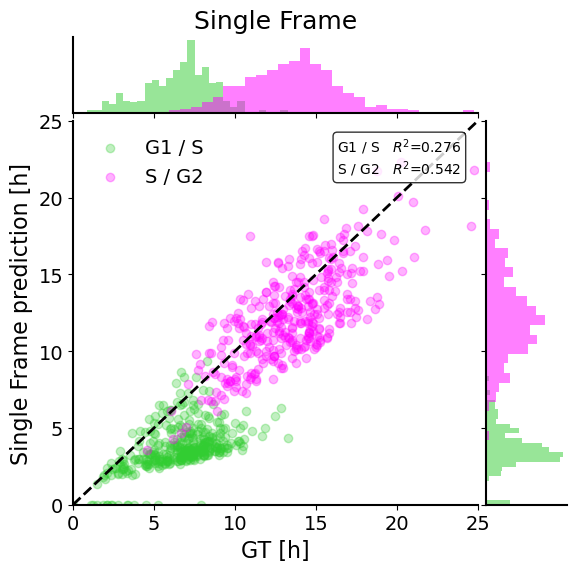

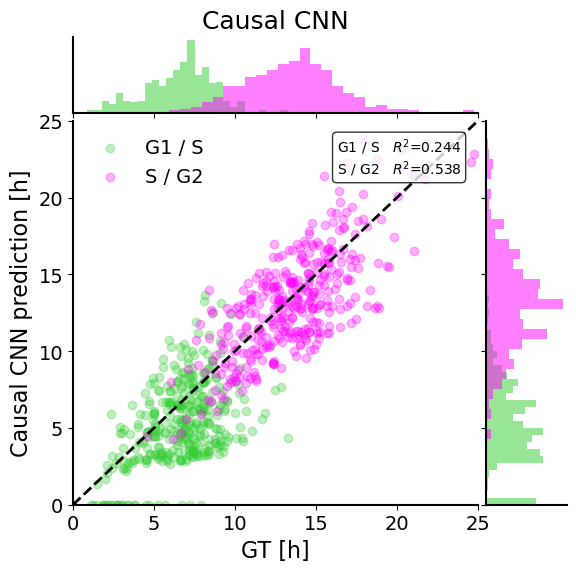

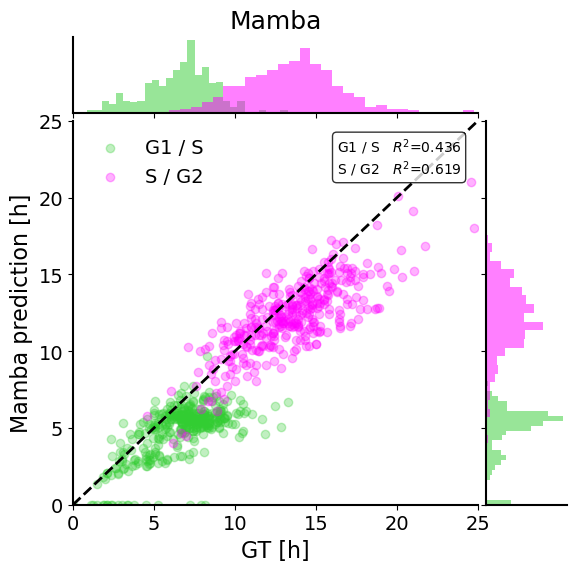

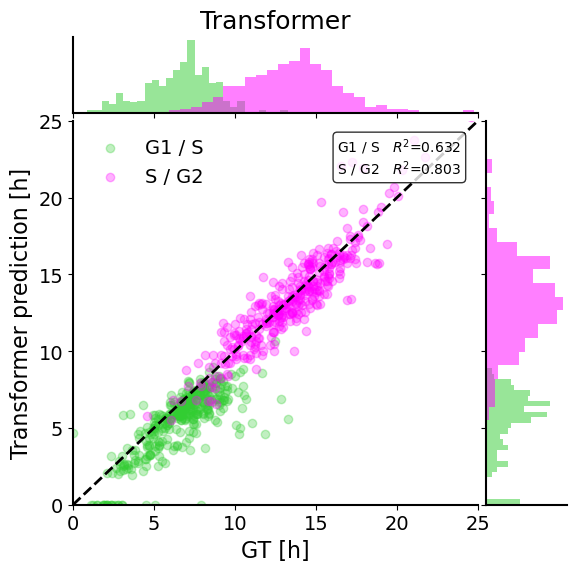

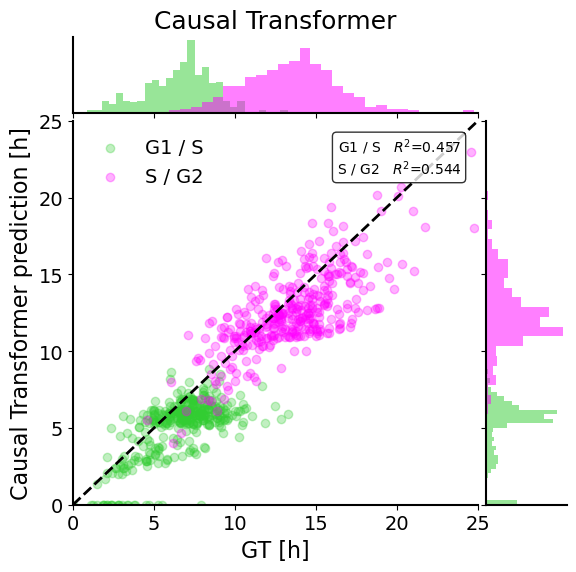

In [10]:
import matplotlib.pyplot as plt
import numpy as np

colors = ["limegreen", "magenta"]
transitions = ["G1 / S", "S / G2"]
plot_heads = ["mamba", "xtransformer"]

for h_idx, head in enumerate(heads):
    # if head not in plot_heads:
    #     continue
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # We'll store R² values to display them collectively on the plot
    r2_list = []
    
    x_data_list = []
    y_data_list = []
    
    for i, c in enumerate(transitions):
        # Data
        x_data = cross_idx_gt[:, i] * fr2h
        y_data = cross_idx[head][:, i] * fr2h
        x_data_list.append(x_data)
        y_data_list.append(y_data)
        
        # Correlation & R²
        r = np.corrcoef(x_data, y_data)[0, 1]
        r2 = r**2
        r2_list.append((c, r2))

        ax.scatter(x_data, y_data, alpha=0.3, color=colors[i], label=c)

    # Force fixed axes range: 0..25
    ax.set_xlim(0, 25)
    ax.set_ylim(0, 25)

    # 1:1 line
    ax.axline([0, 0], slope=1, color="black", linestyle="--")

    # Title and labels
    ax.set_title(f"{head_names_paper[h_idx]}")
    ax.set_xlabel("GT [h]")
    ax.set_ylabel(f"{head_names_paper[h_idx]} prediction [h]")

    # Move legend to a different corner (e.g. upper left)
    ax.legend(loc="upper left")

    # --- Marginal histograms ---
    ax_histx = ax.inset_axes([0.0, 1.02, 1.0, 0.2], sharex=ax)
    ax_histx.xaxis.set_tick_params(labelbottom=False)
    ax_histx.set_yticks([])
    
    ax_histy = ax.inset_axes([1.02, 0.0, 0.2, 1.0], sharey=ax)
    ax_histy.yaxis.set_tick_params(labelleft=False)
    ax_histy.set_xticks([])

    for i, c in enumerate(transitions):
        ax_histx.hist(x_data_list[i], bins=30, alpha=0.5, color=colors[i])
        ax_histy.hist(y_data_list[i], bins=30, alpha=0.5, color=colors[i],
                      orientation='horizontal')

    # --- Annotate with R² ---
    # Build a small summary string
    summary_str = "\n".join([f"{t}   $R^2$={val:.3f}" for (t, val) in r2_list])
    
    # Place annotation so it doesn't overlap legend
    ax.annotate(summary_str,
                xy=(0.96, 0.96),        # near top-right
                xycoords="axes fraction",
                fontsize=10,
                ha="right",
                va="top",
                bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

    plt.tight_layout()
    plt.savefig(f'{head}_correlation.png', bbox_inches='tight', dpi=500)
    plt.show()

In [12]:
ratio = 23.25 / 5.5

100 / ratio

23.655913978494624

In [13]:
# import matplotlib.pyplot as plt
# import numpy as np

# colors = ["limegreen", "magenta"]
# transitions = ["G1 / S", "S / G2"]

# for head in ["cnn", "mamba", "xtransformer-causal","xtransformer"]:
#     fig, ax = plt.subplots(figsize=(6, 6))
    
#     # We'll store R² values to display them collectively on the plot
#     r2_list = []
    
#     x_data_list = []
#     y_data_list = []
    
#     for i, c in enumerate(transitions):
#         # Data
#         x_data = cross_idx_gt_drug[:, i] * fr2h
#         y_data = cross_idx_drug[head][:, i] * fr2h
#         x_data_list.append(x_data)
#         y_data_list.append(y_data)
        
#         # Correlation & R²
#         r = np.corrcoef(x_data, y_data)[0, 1]
#         r2 = r**2
#         r2_list.append((c, r2))

#         ax.scatter(x_data, y_data, alpha=0.3, color=colors[i], label=c)

#     # Force fixed axes range: 0..25
#     ax.set_xlim(0, 25)
#     ax.set_ylim(0, 25)

#     # 1:1 line
#     ax.axline([0, 0], slope=1, color="black", linestyle="--")

#     # Title and labels
#     ax.set_title(f"{head}")
#     ax.set_xlabel("GT [h]")
#     ax.set_ylabel(f"{head} {modality} prediction [h]")

#     # Move legend to a different corner (e.g. upper left)
#     ax.legend(loc="upper left")

#     # --- Marginal histograms ---
#     ax_histx = ax.inset_axes([0.0, 1.02, 1.0, 0.2], sharex=ax)
#     ax_histx.xaxis.set_tick_params(labelbottom=False)
#     ax_histx.set_yticks([])
    
#     ax_histy = ax.inset_axes([1.02, 0.0, 0.2, 1.0], sharey=ax)
#     ax_histy.yaxis.set_tick_params(labelleft=False)
#     ax_histy.set_xticks([])

#     for i, c in enumerate(transitions):
#         ax_histx.hist(x_data_list[i], bins=30, alpha=0.5, color=colors[i])
#         ax_histy.hist(y_data_list[i], bins=30, alpha=0.5, color=colors[i],
#                       orientation='horizontal')

#     # --- Annotate with R² ---
#     # Build a small summary string
#     summary_str = "\n".join([f"{t}   $R^2$={val:.3f}" for (t, val) in r2_list])
    
#     # Place annotation so it doesn't overlap legend
#     ax.annotate(summary_str,
#                 xy=(0.96, 0.96),        # near top-right
#                 xycoords="axes fraction",
#                 fontsize=10,
#                 ha="right",
#                 va="top",
#                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", alpha=0.8))

#     plt.tight_layout()
#     plt.show()